In [1]:
# do GLM & multiple comparisons
import glob
import os 

import pandas as pd
import nibabel as nb
import numpy as np
from scipy.stats import norm

from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
from nilearn.glm.second_level import non_parametric_inference


In [2]:
# get files 
BASE_PATH = os.path.dirname(os.getcwd())
contrasts_path = BASE_PATH + '/contrasts/'
contrasts = sorted(glob.glob(contrasts_path + '*active_minus_sham_mni152_sm00.nii.gz'))


In [23]:
# mask
fsl= os.environ['FSLDIR']
#mask = fsl + '/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
mask = '/home/lauri/Documents/TMS-FDG/tbsfdg/graymask.nii.gz'


In [43]:
second_design_matrix = pd.DataFrame(
    [1] * len(contrasts),
    columns=['intercept'])

second_level_model = SecondLevelModel(smoothing_fwhm=8, mask_img=mask)
second_level_model = second_level_model.fit(
    contrasts,
    design_matrix=second_design_matrix
)


In [44]:
z_map = second_level_model.compute_contrast(
    second_level_contrast='intercept',
    output_type='z_score'
)

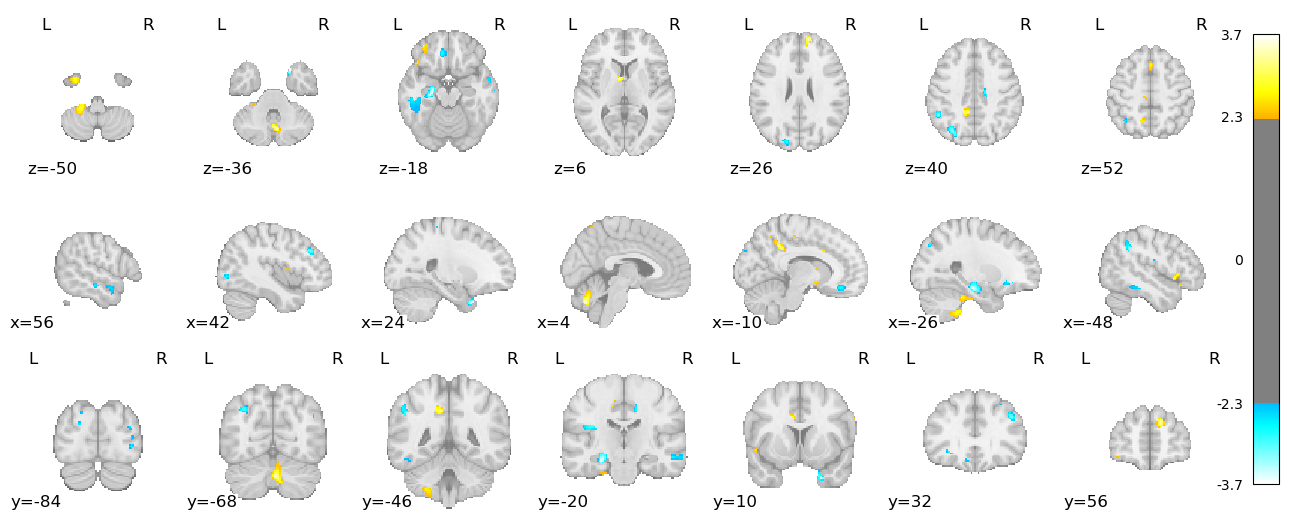

In [45]:
p_val = 0.01
p_unc = norm.isf(p_val)

display = plotting.plot_stat_map(
    z_map,
    threshold=p_unc,
    colorbar=True,
    display_mode='mosaic',
    black_bg=False,
    draw_cross=False)

#fname = PWD+ '/figs/voxel_wise_fear_conditioning_unc_logp3_N53.jpg'
#display.savefig(fname)  # Saves the figure

In [84]:
from nilearn.glm import threshold_stats_img

_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fpr", threshold=3, mask_img=mask)
threshold

1.9599639845400545

In [33]:
?threshold_stats_img

Signature:
threshold_stats_img(
    stat_img=None,
    mask_img=None,
    alpha=0.001,
    threshold=3.0,
    height_control='fpr',
    cluster_threshold=0,
    two_sided=True,
)
Docstring:
Compute the required threshold level and return the thresholded map.

Parameters
----------
stat_img : Niimg-like object or None, optional
   Statistical image (presumably in z scale) whenever height_control
   is 'fpr' or None, stat_img=None is acceptable.
   If it is 'fdr' or 'bonferroni', an error is raised if stat_img is None.

mask_img : Niimg-like object, optional,
    Mask image

alpha : float or list, default=0.001
    Number controlling the thresholding (either a p-value or q-value).
    Its actual meaning depends on the height_control parameter.
    This function translates alpha to a z-scale threshold.

threshold : float, default=3.0
   Desired threshold in z-scale.
   This is used only if height_control is None.

height_control : string, or None optional, default='fpr'
    False positive

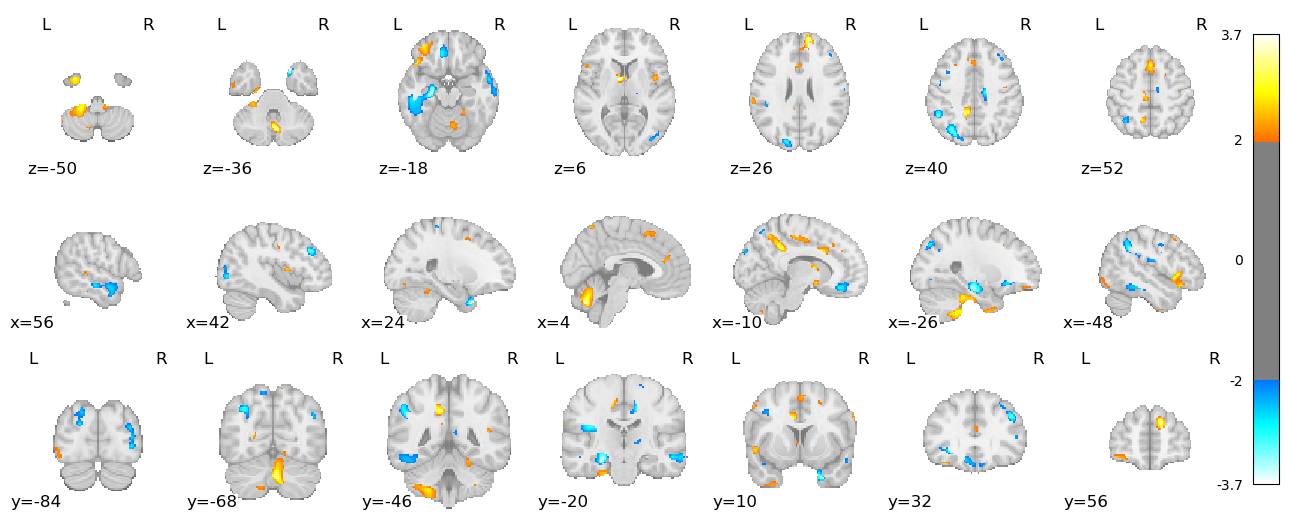

In [85]:

plotting.plot_stat_map(
    z_map,
    threshold=threshold,
    display_mode='mosaic',
    colorbar=True
)
plotting.show()

In [91]:
out_dict = non_parametric_inference(
    contrasts,
    design_matrix=second_design_matrix,
    second_level_contrast='intercept',
    model_intercept=True,
    n_perm=1000,
    two_sided_test=True,
    smoothing_fwhm=8,
    n_jobs=4,
    threshold=0.01,
    mask = mask,
    tfce=True
)

/home/lauri/.local/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/lauri/.local/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [90]:
?non_parametric_inference

Signature:
non_parametric_inference(
    second_level_input,
    confounds=None,
    design_matrix=None,
    second_level_contrast=None,
    first_level_contrast=None,
    mask=None,
    smoothing_fwhm=None,
    model_intercept=True,
    n_perm=10000,
    two_sided_test=False,
    random_state=None,
    n_jobs=1,
    verbose=0,
    threshold=None,
    tfce=False,
)
Docstring:
Generate p-values corresponding to the contrasts provided     based on permutation testing.

This function is a light wrapper around
:func:`~nilearn.mass_univariate.permuted_ols`, with additional steps to
ensure compatibility with the :mod:`~nilearn.glm.second_level` module.

Parameters
----------

second_level_input : :obj:`list` of     :class:`~nilearn.glm.first_level.FirstLevelModel` objects or     :class:`pandas.DataFrame` or     :obj:`list` of Niimg-like objects or     :obj:`pandas.Series` of Niimg-like objects.

    - Giving :class:`~nilearn.glm.first_level.FirstLevelModel` objects
      will allow to easily

In [92]:

signed_p = np.sign(out_dict['t'].get_fdata()) * out_dict['logp_max_t'].get_fdata()
signed_p_img = nb.Nifti1Image(signed_p, out_dict['t'].affine)

print(np.max(np.sign(out_dict['t'].get_fdata())), np.min(np.sign(out_dict['t'].get_fdata())))
print(np.max(np.sign(out_dict['logp_max_t'].get_fdata())), np.min(np.sign(out_dict['logp_max_t'].get_fdata())))

1.0 -1.0
1.0 0.0


In [93]:
out_dict

{'t': <nibabel.nifti1.Nifti1Image at 0x71d243e0ff50>,
 'logp_max_t': <nibabel.nifti1.Nifti1Image at 0x71d24311d1d0>,
 'tfce': <nibabel.nifti1.Nifti1Image at 0x71d24311d150>,
 'logp_max_tfce': <nibabel.nifti1.Nifti1Image at 0x71d24311d090>,
 'size': <nibabel.nifti1.Nifti1Image at 0x71d24417c110>,
 'logp_max_size': <nibabel.nifti1.Nifti1Image at 0x71d243e0c6d0>,
 'mass': <nibabel.nifti1.Nifti1Image at 0x71d24c5af3d0>,
 'logp_max_mass': <nibabel.nifti1.Nifti1Image at 0x71d243e0ddd0>}

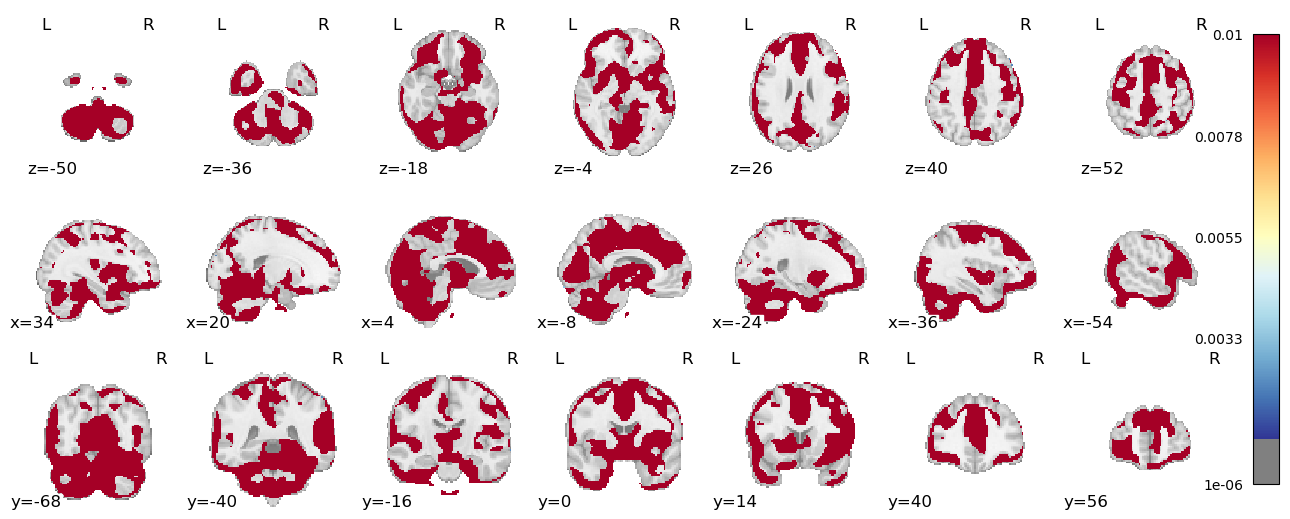

In [95]:
display = plotting.plot_stat_map(
    out_dict['tfce'],
    colorbar=True,
    display_mode='mosaic',
    black_bg=False,
    draw_cross=False,
    cmap='RdYlBu_r',
    vmin=0.001,
    vmax=0.01)

plotting.show()